# Imports

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error, matthews_corrcoef
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score



#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv





import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp



from openfe import OpenFE, transform
from autogluon.tabular import TabularDataset, TabularPredictor

import h2o
from h2o.automl import H2OAutoML

import gc

from xgboost import plot_importance
import wandb
from fastai.callback.wandb import *
from wandb.integration.lightgbm import wandb_callback, log_summary
#from wandb.xgboost import wandb_callback



#from IPython.display import FileLink

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
path = Path('playground-series-s4e8/')
path

Path('playground-series-s4e8')

In [3]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
secondary_data = pd.read_csv(path/'secondary_data.csv',sep=";")

In [4]:
train_df.shape

(3116945, 21)

In [5]:
train_df = pd.concat([train_df, secondary_data], ignore_index=True)

In [6]:
secondary_data.shape

(61069, 21)

In [7]:
train_df.shape

(3178014, 21)

In [8]:
# Make a copy of the training dataframe to avoid modifying the original
train_df_with_nan = train_df.copy()

# Add a NaN value to a random row in the 'stem-height' column
random_index = np.random.choice(train_df_with_nan.index)
train_df_with_nan.loc[random_index, 'stem-height'] = np.nan

# Verify the NaN was added
print(train_df_with_nan['stem-height'].isna().sum())

1


In [9]:
cont_names,cat_names = cont_cat_split(train_df_with_nan, dep_var='class')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df_with_nan))
to = TabularPandas(train_df_with_nan, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df_with_nan, procs=[Categorify, Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='class',
                   y_block=CategoryBlock(),
                   splits=splits)



In [10]:
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

In [11]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [12]:
to

         class  cap-diameter  cap-shape  cap-surface  cap-color  \
1113546      1      1.031673         72           54         77   
2375898      1      0.382139         72           57         67   
1248111      1     -0.850474         72           56         64   
999796       1     -0.543929         54            0         64   
1712984      0     -0.149492         68            0         64   
...        ...           ...        ...          ...        ...   
225399       0     -1.041261         72           80         64   
2763294      1     -0.087326         49           73         58   
443942       1      2.864516         68           48         64   
567621       0     -0.005866         72           82         64   
1498605      1      0.122755         68           57         67   

         does-bruise-or-bleed  gill-attachment  gill-spacing  gill-color  \
1113546                    21               67             0          35   
2375898                     9              

In [13]:
train_df_with_nan.shape

(3178014, 21)

In [45]:
X_train.shape

(2542412, 20)

# Voting

In [46]:
learn = tabular_learner(dls, metrics=MatthewsCorrCoef())
#learn.fit_one_cycle(10)

In [18]:
#nn_model = learn.load('mushroom_prediction_model_colab')

In [18]:
xgb_optuna_params = {
              
    'num_leaves': 375, 
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 1851, 
    'subsample_for_bin': 104472,
    'min_child_samples': 454,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 20,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,
    
    #'device': 'gpu'
}

"""
lgbm_params = {
    #'n_estimators': 2500,
    'n_estimators': 5000,
    'learning_rate': 0.16946407558813623,
    'num_leaves': 120,
    'max_depth': 5,
    'min_data_in_leaf': 9400,
    'max_bin': 300,
    'lambda_l1': 0,
    'lambda_l2': 100,
    'min_gain_to_split': 0.12639861649831552,
    'bagging_fraction': 0.6,
    'bagging_freq': 1,
    'feature_fraction': 0.9
}
"""

lgbm_params = {
    #'n_estimators': 2500,
    'num_leaves': 227,
    'learning_rate': 0.06737922153052582,
    'n_estimators': 357,
    'subsample_for_bin': 213892,
    'min_child_samples': 292,
    'reg_alpha': 4.5070762908503614e-07,
    'reg_lambda': 0.00017079711660762664,
    'colsample_bytree': 0.45636430645506504,
    'subsample': 0.6819598716671345,
    'max_depth': 14
}

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    #"task_type": 'GPU',
    "cat_features": cat_names
}

In [19]:
xgb_model = xgb.XGBClassifier(**xgb_optuna_params)
#xgb_model = xgb_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(500, min_samples_leaf=3)
#rf_model = rf.fit(X_train, y_train)
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
#lgbm_model = lgbm_model.fit(X_train, y_train)
cat_model = CatBoostClassifier(**cat_params)
#cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch

class FastaiLearnerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, learner):
        self.learner = learner
        self.classes_ = np.array(self.learner.dls.vocab)  # Assuming binary classification
    
    def fit(self, X, y=None):
        # Since the learner is already trained, we don't need to do anything here
        return self
    
    def predict(self, X):
        # Convert input to fastai DataLoader
        X_dl = self.learner.dls.test_dl(X)
        # Get predictions
        _, preds, _ = self.learner.get_preds(dl=X_dl, with_decoded=True)
        return preds.numpy().argmax(axis=1)
    
    def predict_proba(self, X):
        # Convert input to fastai DataLoader
        X_dl = self.learner.dls.test_dl(X)
        # Get predictions
        preds, _, _ = self.learner.get_preds(dl=X_dl, with_decoded=True)
        return preds.numpy()


In [20]:
nn_model_wrapper = FastaiLearnerWrapper(learn)


In [21]:
%%time
# Assuming rf_model and xgb_model are already fitted models
# Wrap them in a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),  # Replace rf_model with the actual RandomForestClassifier instance
    ('xgb', xgb_model),  # Replace xgb_model with the actual XGBoostClassifier instance
    ('cat', cat_model),  # Replace rf_model with the actual RandomForestClassifier instance
    ('lgb', lgbm_model),
    #('nn', nn_model_wrapper)
    #('nn', nn_model)
], voting='soft')

# Now, you can use the VotingClassifier to make predictions
# Note: The VotingClassifier expects scikit-learn compatible inputs
# So, you'll need to convert your PyTorch tensors to NumPy arrays or Pandas DataFrames
# Here's an example assuming X_test is your test data in a PyTorch tensor format
#X_test_np = X_test.numpy()  # Convert PyTorch tensor to NumPy array

voting_clf.fit(X_train, y_train)

#predictions = voting_clf.predict(X_test)

# Calculate the accuracy score
#accuracy = accuracy_score(y_test, predictions)
#print(f"Accuracy: {accuracy:.6f}")

In [ ]:
%%time
predictions = voting_clf.predict(X_test)
predictions

CPU times: user 3min 49s, sys: 42.5 ms, total: 3min 49s
Wall time: 1min 52s


array([1, 0, 1, ..., 1, 0, 1], dtype=int8)

In [ ]:
%%time
voting_score = matthews_corrcoef(y_test, predictions)
voting_score

CPU times: user 78 ms, sys: 18 µs, total: 78.1 ms
Wall time: 80.2 ms


0.9849878696956649

In [ ]:
%%time
voting_preds = voting_clf.predict(test_dl.xs)
voting_preds

CPU times: user 12min 25s, sys: 486 ms, total: 12min 25s
Wall time: 6min 5s


array([0, 1, 1, ..., 1, 0, 0], dtype=int8)

In [ ]:
predictions_tensor = torch.from_numpy(predictions)
voting_preds_tensor = torch.from_numpy(voting_preds)

In [ ]:
!rm submission.csv 
!ls

AutogluonModels  playground-series-s4e8		     wandb
lgbm_model.pkl	 playground-series-s4e8.zip	     xgb_model.json
main.py		 poisonous_mushrooms_classification
models		 requirements.txt


In [30]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in voting_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [31]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[VOTING CLASSIFIER] Silver Rubanza, VOTING CLASSIFIER soft voting with NaNs sub 6 XGB,LGBM,RF,CB + original ds  - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 39.4MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

In [ ]:
!rm submission.csv

# Stacking

In [ ]:
stacking_estimators = [
    ('cat_boost',cat_model),
    ('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

In [ ]:
clf = StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=xgb.XGBClassifier(**xgb_optuna_params),
    cv=5
)

In [ ]:
%%time
clf.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 1364536, number of negative: 1129020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547225 -> initscore=0.189464
[LightGBM] [Info] Start training from score 0.189464


In [ ]:
stacking_preds_x = clf.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_gain_to_split is set=0.12639861649831552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12639861649831552
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [ ]:
stacking_preds = (clf.predict(test_dl.xs))

[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_gain_to_split is set=0.12639861649831552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12639861649831552
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [ ]:


stacking_score = matthews_corrcoef(y_test,stacking_preds_x)
stacking_score


In [ ]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in stacking_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

In [ ]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[STACKING ENSEMBLE] Silver Rubanza,  Stacking ensemble sub 2 -cat,rf,xgb,lgbm  - lightning  "

# XgBoost

In [15]:
%%time
xgb_model = xgb.XGBClassifier(**xgb_optuna_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = matthews_corrcoef(y_test,xgb_preds_x)
xgb_score

CPU times: user 30min 30s, sys: 1.1 s, total: 30min 31s
Wall time: 15min 17s


0.9849692888461782

In [78]:
%%time
K_FOLDS = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    xgb_model_fold = xgb.XGBClassifier(**xgb_optuna_params)
    xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = xgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    score = matthews_corrcoef(y_fold_val, y_pred_fold)
    fold_scores.append(score)
    
    print(f"Fold {fold} MCC: {score}")

# Calculate and print the mean score across all folds
mean_score = np.mean(fold_scores)
print(f"Mean MCC: {mean_score}")

Fold 1 MCC: 0.9851586447665185
Fold 2 MCC: 0.9849560304581464
Fold 3 MCC: 0.9847898442800908
Fold 4 MCC: 0.9849919259273856
Fold 5 MCC: 0.9853004951894506
Mean MCC: 0.9850393881243183
CPU times: user 2h 2min 13s, sys: 4.14 s, total: 2h 2min 17s
Wall time: 1h 1min 42s


In [18]:
#without original dataset
xgb_score

0.9816297021275638

In [54]:
#without original dataset
xgb_score,mean_score

(0.9847934802058209, 0.984725297629683)

In [79]:
#with original dataset
xgb_score,mean_score

(0.9849925811636054, 0.9850393881243183)

In [22]:
#with original ds no fill missing
#should be higher than 0.9849925811636054
xgb_score

0.984940714578072

In [49]:
#with original dataset - 2000 estimators
xgb_score

0.9847901835973488

In [80]:
y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)

In [21]:
xgb_preds

tensor([0, 1, 1,  ..., 1, 0, 0])

In [11]:
xgb_score

0.9846685637768

In [12]:
#3rd trial
xgb_score

0.9846685637768

In [11]:
xgb_score

0.9847493710839511

>0.9847493710839511

In [81]:
!rm submission.csv
!ls

AutogluonModels  playground-series-s4e8		     wandb
lgbm_model.pkl	 playground-series-s4e8.zip	     xgb_model.json
main.py		 poisonous_mushrooms_classification
models		 requirements.txt


In [82]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in xgb_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

rm: cannot remove 'submission.csv': No such file or directory
              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [83]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBoost PREDS] Silver Rubanza,  XGBoost optuna tuned preds + original dataset   - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 39.6MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

In [84]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in y_pred_fold_tt]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [85]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBoost Cross val PREDS] Silver Rubanza,  XGBoost optuna tuned preds + original dataset with cross validation   - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 45.9MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

does increasing no of folds improve score ?

In [87]:
%%time
K_FOLDS = 10  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    xgb_model_fold = xgb.XGBClassifier(**xgb_optuna_params)
    xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = xgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    score = matthews_corrcoef(y_fold_val, y_pred_fold)
    fold_scores.append(score)
    
    print(f"Fold {fold} MCC: {score}")

# Calculate and print the mean score across all folds
mean_score = np.mean(fold_scores)
print(f"Mean MCC: {mean_score}")

Fold 1 MCC: 0.9853205555939345
Fold 2 MCC: 0.9849336923748926


# Neural Network

In [13]:
learn = tabular_learner(dls, metrics=MatthewsCorrCoef())
#learn.fit_one_cycle(10)

In [ ]:
learn.load('mushroom_prediction_model_colab')

SuggestedLRs(valley=0.002511886414140463)

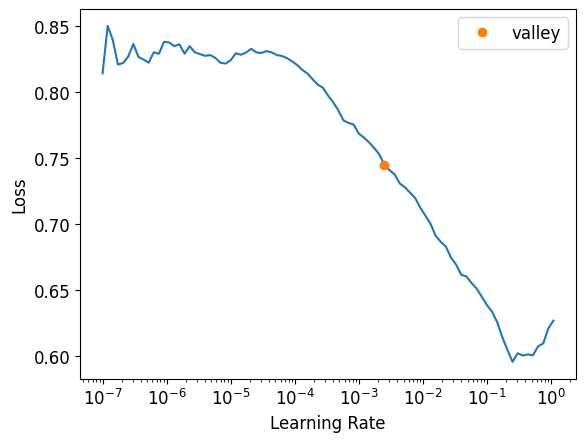

In [14]:
learn.lr_find()

In [ ]:
#learn.fit_one_cycle(3,wd=0.2)

In [15]:
%%time
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.052140,0.042466,0.982087,03:40
1,0.037805,0.041655,0.982751,03:42
2,0.045454,0.039550,0.983269,03:43
3,0.039136,0.038912,0.983568,03:43
4,0.036333,0.038873,0.983440,03:43
5,0.043091,0.039617,0.983060,03:44
6,0.036053,0.038226,0.983886,03:48
7,0.042104,0.037770,0.983992,03:48
8,0.046217,0.037500,0.984103,03:50
9,0.038668,0.037593,0.984062,03:48


CPU times: user 1h 14min 32s, sys: 9.83 s, total: 1h 14min 42s
Wall time: 37min 34s


In [16]:
learn.save('nn_model_with_orig_ds')

Path('models/nn_model_with_orig_ds.pth')

In [17]:
dl = test_dl
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba_b = (a_preds[:, 1])

In [18]:
final_preds_scoring = nn_preds_x[:, 1]

In [19]:
rounded_nn_scoring_preds = torch.round(final_preds_scoring).long()
rounded_nn_scoring_preds

tensor([1, 0, 1,  ..., 1, 0, 1])

In [20]:
nn_score = matthews_corrcoef(y_test,rounded_nn_scoring_preds)
print(f"Final Neural Network MCC on test set: {nn_score}")

Final Neural Network MCC on test set: 0.984062397021398


Baseline is Final Neural Network MCC on test set: 0.9838791737078751

In [21]:
learn.load('nn_model_with_orig_ds')

In [24]:
%%time
#With original ds
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.043910,0.038484,0.983705,03:47
1,0.046760,0.039907,0.983187,03:46
2,0.028306,0.039705,0.983485,03:49
3,0.037673,0.039400,0.983483,03:47
4,0.038803,0.038813,0.983563,03:48
5,0.038441,0.039039,0.983487,03:47
6,0.046396,0.037830,0.983859,03:45
7,0.036983,0.038048,0.983879,03:46
8,0.040467,0.037762,0.983994,03:44
9,0.030490,0.037474,0.984036,03:47


CPU times: user 1h 15min 5s, sys: 9.25 s, total: 1h 15min 14s
Wall time: 37min 51s


In [25]:
dl = test_dl
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba_b = (a_preds[:, 1])
final_preds_scoring = nn_preds_x[:, 1]
rounded_nn_scoring_preds = torch.round(final_preds_scoring).long()
nn_score = matthews_corrcoef(y_test,rounded_nn_scoring_preds)
print(f"Final Neural Network MCC on test set: {nn_score}")

Final Neural Network MCC on test set: 0.9840356126100089


In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.043609,0.039497,0.983430,04:11
1,0.043301,0.038516,0.983664,04:13
2,0.038330,0.038213,0.983683,04:16


# LGBM

 > 9.35 BASELINE

In [16]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

#validation set preds
lgbm_preds_x = tensor(lgbm_model.predict(X_test))


#lgb_preds_x_prob = tensor(lgb_model.predict_proba(X_test))

lgbm_score = matthews_corrcoef(y_test,lgbm_preds_x)
lgbm_score


[LightGBM] [Info] Number of positive: 1391810, number of negative: 1150602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 2542412, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547437 -> initscore=0.190320
[LightGBM] [Info] Start training from score 0.190320
CPU times: user 3min 59s, sys: 412 ms, total: 3min 59s
Wall time: 2min


0.984727675882211

In [31]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

#validation set preds
lgbm_preds_x = tensor(lgbm_model.predict(X_test))


#lgb_preds_x_prob = tensor(lgb_model.predict_proba(X_test))

lgbm_score = matthews_corrcoef(y_test,lgbm_preds_x)
lgbm_score


[LightGBM] [Info] Number of positive: 1391810, number of negative: 1150602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.278324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 2542412, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547437 -> initscore=0.190320
[LightGBM] [Info] Start training from score 0.190320
CPU times: user 3min 55s, sys: 945 ms, total: 3min 56s
Wall time: 1min 59s


0.984727675882211

In [11]:
%%time
K_FOLDS = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    lgbm_model_fold = lgb.LGBMClassifier(**lgbm_params)
    lgbm_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = lgbm_model_fold.predict(X_fold_val)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    score = matthews_corrcoef(y_fold_val, y_pred_fold)
    fold_scores.append(score)
    
    print(f"Fold {fold} MCC: {score}")

# Calculate and print the mean score across all folds
mean_score = np.mean(fold_scores)
print(f"Mean MCC: {mean_score}")

[LightGBM] [Info] Number of positive: 1091628, number of negative: 903216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1994844, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547225 -> initscore=0.189464
[LightGBM] [Info] Start training from score 0.189464
Fold 1 MCC: 0.9845946642646747
[LightGBM] [Info] Number of positive: 1091629, number of negative: 903216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 1994845, number of

In [32]:
#with original ds
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.984727675882211


In [14]:
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.9845321298854594


In [12]:
#WITHOUT NANS- USING FILL MISSING
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.9844770580395102


In [17]:
print(f"Mean MCC: {mean_score}")

Mean MCC: 0.9845217158539917


In [13]:
#WITHOUT NANS USING FILLMISSING
print(f"Mean MCC: {mean_score}")

Mean MCC: 0.9844802787018698


In [27]:
print(f"Final LGBM MCC on test set: {lgbm_score}")

Final LGBM MCC on test set: 0.9844417245982304


In [14]:
#10000 estimators
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.9841022260741565


In [11]:
#5000 estimators
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.9841250711521743


In [11]:
print(f"Final Neural Network MCC on test set: {lgbm_score}")

Final Neural Network MCC on test set: 0.9840244628142798


In [14]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in lgbm_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [15]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[LGBM PREDS] Silver Rubanza,  SUJAY OPTUNA  - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 48.5MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

# Ensemble

In [ ]:
# Assign weights based on model performance
total_score = nn_score + xgb_score + lgbm_score
nn_weight = nn_score / total_score
xgb_weight = xgb_score / total_score
lgbm_weight = lgbm_score / total_score

# Weighted blend
weighted_blend_preds = (nn_weight * nn_preds_test + 
                        xgb_weight * xgb_preds_test + 
                        lgbm_weight * lgbm_preds_test)

rounded_weighted_blend_preds = torch.round(weighted_blend_preds).long()

## For scoring

### LGBM + XGB

In [17]:
xgb_lgbm = (lgbm_preds_x + xgb_preds_x)/2
rounded_xgb_lgbm_preds = torch.round(xgb_lgbm).long()
xgb_lgbm_score = matthews_corrcoef(y_test,rounded_xgb_lgbm_preds)
print(f"Final XGB-LGBM MCC on test set: {xgb_lgbm_score}")

Final XGB-LGBM MCC on test set: 0.9848254729941965


>Final XGB-LGBM MCC on test set: 0.9843371651003854

In [ ]:
predictions_tensor = torch.from_numpy(predictions)
voting_preds_tensor = torch.from_numpy(voting_preds)

In [ ]:
predictions_tensor.shape,xgb_preds_x.shape

(torch.Size([623389]), torch.Size([623389]))

### Voting preds + XGB

In [ ]:
xgb_voting_clf = (predictions_tensor + xgb_preds_x)/2
rounded_xgb_voting_clf_preds = torch.round(xgb_voting_clf).long()
xgb_voting_clf_score = matthews_corrcoef(y_test,rounded_xgb_voting_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_voting_clf_score}")

Final XGB-VOTING MCC on test set: 0.9846285430578156


Final XGB-VOTING MCC on test set: 0.9846285430578156

### Voting preds + LGBM

In [ ]:
lgbm_voting_clf = (predictions_tensor + lgbm_preds_x)/2
rounded_lgbm_voting_clf_preds = torch.round(lgbm_voting_clf).long()
lgbm_voting_clf_score = matthews_corrcoef(y_test,rounded_lgbm_voting_clf_preds)
print(f"Final LGBM-VOTING MCC on test set: {lgbm_voting_clf_score}")

Final LGBM-VOTING MCC on test set: 0.9842323739641381


Final LGBM-VOTING MCC on test set: 0.9842323739641381

### Voting preds + XGB + LGBM

In [ ]:
xgb_lgbm_voting_clf = (predictions_tensor + lgbm_preds_x + xgb_preds_x)/3
rounded_xgb_lgbm_voting_clf_preds = torch.round(xgb_lgbm_voting_clf).long()
xgb_lgbm_voting_clf_score = matthews_corrcoef(y_test,rounded_xgb_lgbm_voting_clf_preds)
print(f"Final xgb-LGBM-VOTING MCC on test set: {xgb_lgbm_voting_clf_score}")

Final xgb-LGBM-VOTING MCC on test set: 0.9845939235730832


Final xgb-LGBM-VOTING MCC on test set: 0.9845939235730832

### XGB + STACKING

In [ ]:
xgb_preds_x.shape,stacking_preds.shape

In [ ]:
xgb_voting_clf = (stacking_preds_x + xgb_preds_x)/2
rounded_xgb_voting_clf_preds = torch.round(xgb_voting_clf).long()
xgb_voting_clf_score = matthews_corrcoef(y_test,rounded_xgb_voting_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_voting_clf_score}")

In [ ]:
xgb_stacking_clf = (stacking_preds_x + xgb_preds_x)/2
rounded_xgb_stacking_clf_preds = torch.round(xgb_stacking_clf).long()
xgb_stacking_clf_score = matthews_corrcoef(y_test,rounded_xgb_stacking_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_stacking_clf_score}")

### XGB + STACKING + VOTING

In [ ]:
xgb_voting_stacking_clf = (stacking_preds_x + xgb_preds_x + predictions_tensor)/3
rounded_xgb_voting_stacking_clf_preds = torch.round(xgb_voting_stacking_clf).long()
xgb_voting_stacking_clf_score = matthews_corrcoef(y_test,rounded_xgb_voting_stacking_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_voting_stacking_clf_score}")

### XGB + LGBM + STACKING + VOTING

In [ ]:
xgb_lgbm_voting_stacking_clf = (stacking_preds_x + xgb_preds_x + lgbm_preds_x + predictions_tensor)/4
rounded_xgb_lgbm_voting_stacking_clf_preds = torch.round(xgb_lgbm_voting_stacking_clf).long()
xgb_lgbm_voting_stacking_clf_score = matthews_corrcoef(y_test,rounded_xgb_lgbm_voting_stacking_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_lgbm_voting_stacking_clf_score}")

In [ ]:
print(f"Final XGB-VOTING MCC on test set: {xgb_lgbm_voting_stacking_clf_score}")

In [ ]:
print(f"Final XGB-VOTING MCC on test set: {xgb_lgbm_voting_stacking_clf_score}")

### LGBM + STACKING + VOTING

In [ ]:
lgbm_voting_stacking_clf = (stacking_preds_x + lgbm_preds_x + predictions_tensor)/3
rounded_lgbm_voting_stacking_clf_preds = torch.round(lgbm_voting_stacking_clf).long()
xgb_voting_stacking_clf_score = matthews_corrcoef(y_test,rounded_lgbm_voting_stacking_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {lgbm_voting_stacking_clf_score}")

###  STACKING + VOTING

In [ ]:
stacking_voting_clf = (stacking_preds_x + predictions_tensor)/2
rounded_stacking_voting_clf_preds = torch.round(stacking_voting_clf).long()
stacking_voting_clf_score = matthews_corrcoef(y_test,rounded_stacking_voting_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {stacking_voting_clf_score}")

In [ ]:
print(f"Final XGB-VOTING MCC on test set: {stacking_voting_clf_score}")

In [ ]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING','XGB-VOTING'],
    'acc': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,lgbm_voting_clf_score,xgb_voting_clf_score]
})

accuracy_sorted_b = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_b

In [ ]:
xgb_voting_clf = (predictions_tensor + xgb_preds_x)/2
rounded_xgb_voting_clf_preds = torch.round(xgb_voting_clf).long()
xgb_voting_clf_score = matthews_corrcoef(y_test,rounded_xgb_voting_clf_preds)
print(f"Final XGB-VOTING MCC on test set: {xgb_voting_clf_score}")

In [ ]:
mcc_d = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING',
    'XGB-VOTING','XGB-STACKING','XGB-VOTING-STACKING','XGB-LGBM-VOTING-STACKING','LGBM-VOTING-STACKING','STACKING-VOTING'],
    'mcc': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,
    lgbm_voting_clf_score,xgb_voting_clf_score,xgb_stacking_clf_score,xgb_voting_stacking_clf_score,
    xgb_lgbm_voting_stacking_clf_score,lgbm_voting_stacking_clf_score,stacking_voting_clf_score ]
})

mcc_sorted_d = mcc_d.sort_values(by='mcc_d', ascending=False)
mcc_sorted_d

### Accuracy DF

In [25]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING','XGB-VOTING'],
    'MCC': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,lgbm_voting_clf_score,xgb_voting_clf_score]
})

accuracy_sorted_b = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_b

,algoritm,acc
1,xgboost,0.984749
5,XGB-VOTING,0.984629
3,xgb-LGBM-VOTING,0.984594
2,XGB-LGBM,0.984337
4,LGBM-VOTING,0.984232
0,lgbm,0.984125


In [ ]:
xgb_lgbm_score,lgbm_score,xgb_score

(0.9843371651003854, 0.9841250711521743, 0.9847493710839511)

In [ ]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost','XGB-VOTING'],
    'acc': [lgbm_score, xgb_score,xgb_voting_clf_score]
})

accuracy_sorted_a = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_a

,algoritm,acc
1,xgboost,0.984749
2,XGB-LGBM,0.984272
0,lgbm,0.984024


In [ ]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING',
    'XGB-VOTING'],
    'acc': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,
    lgbm_voting_clf_score,xgb_voting_clf_score]
})

accuracy_sorted_b = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_b

In [ ]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING','XGB-VOTING','VOTING','STACKING'],
    'acc': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,lgbm_voting_clf_score,xgb_voting_clf_score,voting_score,stacking_score]
})

accuracy_sorted_b = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_b

In [52]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'XGB-LGBM','xgb-LGBM-VOTING','LGBM-VOTING','XGB-VOTING'],
    'acc': [lgbm_score, xgb_score, xgb_lgbm_score ,xgb_lgbm_voting_clf_score,lgbm_voting_clf_score,xgb_voting_clf_score]
})

accuracy_sorted_b = acc.sort_values(by='acc', ascending=False)
accuracy_sorted_b

,algoritm,acc
1,xgboost,0.984749
5,XGB-VOTING,0.984629
3,xgb-LGBM-VOTING,0.984594
2,XGB-LGBM,0.984337
4,LGBM-VOTING,0.984232
0,lgbm,0.984125


In [ ]:
acc = pd.DataFrame({
    'algoritm': ['lgbm', 'xgboost', 'cat_boost', 'xgboost + lgbm ', 'xgboost + lgbm + cat_boost',
     'xgboost + cat_boost', 'lgbm + cat_boost','neural_network','xgb + nn',
     'nn_score + lgbm + xgb + cat','nn_score + lgbm + cat','nn_score + xgb + cat' ],
    'acc': [lgbm_score, xgb_score, cat_score,xgb_lgbm_score,xgb_lgbm_cat_score,
    xgb_cat_score,lgbm_cat_score, nn_score,xgb_nn_a_score,xgb_lgbm_cat_nn_score, lgbm_cat_nn_score,xgb_cat_nn_score ]
})

accuracy_sorted = acc.sort_values(by='acc', ascending=False)
accuracy_sorted

## For submission

In [26]:
xgb_lgbm_sub = (xgb_preds + lgbm_preds)/2
rounded_xgb_lgbm_sub_preds = torch.round(xgb_lgbm_sub).long()
rounded_xgb_lgbm_sub_preds

tensor([0, 1, 1,  ..., 1, 0, 0])

In [28]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in rounded_xgb_lgbm_sub_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [29]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBOOST+LGBM] Silver Rubanza, XGBOOST + SUJAY 5000 estimators LGBM optuna tuned params - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 42.7MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

### LGBM, XGB + VOTING PREDS

In [33]:
voting_preds.shape,lgbm_preds.shape,xgb_preds.shape

((2077964,), torch.Size([2077964]), torch.Size([2077964]))

XGB + VOTING CLF

In [27]:
xgb_voting_clf_sub = (xgb_preds + voting_preds)/2
rounded_xgb_voting_clf_sub_preds = torch.round(xgb_voting_clf_sub).long()
rounded_xgb_voting_clf_sub_preds

tensor([0, 1, 1,  ..., 1, 0, 0])

In [28]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in rounded_xgb_voting_clf_sub_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

rm: cannot remove 'submission.csv': No such file or directory


              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [29]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBOOST+VOTING CLASSIFIER] Silver Rubanza, XGBOOST + VOTING CLASSIFIER PREDS sub 3 - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 45.6MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

XGB + LBM + VOTING CLF

In [30]:
xgb_lgbm_voting_clf_sub = (xgb_preds + voting_preds+ lgbm_preds)/3
rounded_xgb_lgbm_voting_clf_sub_preds = torch.round(xgb_lgbm_voting_clf_sub).long()
rounded_xgb_voting_clf_sub_preds

tensor([0, 1, 1,  ..., 1, 0, 0])

In [31]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in rounded_xgb_lgbm_voting_clf_sub_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

              id class
0        3116945     e
1        3116946     p
2        3116947     p
3        3116948     p
4        3116949     e
...          ...   ...
2077959  5194904     p
2077960  5194905     p
2077961  5194906     p
2077962  5194907     e
2077963  5194908     e

[2077964 rows x 2 columns]


In [32]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBOOST+LGBM+VOTING] Silver Rubanza, XGBOOST + SUJAY LGBM optuna tuned params - lightning  "

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 46.1MB/s]
Successfully submitted to Binary Prediction of Poisonous Mushrooms

## LGBM + VOTING CLF

In [ ]:
lgbm_voting_clf_sub = (lgbm_preds + voting_preds)/2
rounded_lgbm_voting_clf_sub_preds = torch.round(lgbm_voting_clf_sub).long()
rounded_lgbm_voting_clf_sub_preds

## XGB + VOTING

In [ ]:
xgb_voting_clf_sub = (xgb_preds + voting_preds)/2
rounded_xgb_voting_clf_sub_preds = torch.round(xgb_voting_clf_sub).long()
rounded_xgb_voting_clf_sub_preds

In [ ]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['class'] = [mapping[pred.item()] for pred in rounded_xgb_voting_clf_sub_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
print(sub)

In [ ]:
!kaggle competitions submit -c playground-series-s4e8 -f submission.csv -m "[XGBOOST+VOTING] Silver Rubanza, XGBOOST + VOTING With original ds - lightning  "

## Stacking + xgbm

In [ ]:
xgb_stacking_clf_sub = (xgb_preds + stacking_preds)/2
rounded_xgb_stacking_clf_sub_preds = torch.round(xgb_stacking_clf_sub ).long()
rounded_xgb_stacking_clf_sub_preds

## Stacking + LGBM

In [ ]:
lgbm_stacking_clf_sub = (lgbm_preds + stacking_preds)/2
rounded_lgbm_stacking_clf_sub_preds = torch.round(lgbm_stacking_clf_sub ).long()
rounded_lgbm_stacking_clf_sub_preds

## Stacking + Voting

In [ ]:
voting_stacking_clf_sub = (voting_preds + stacking_preds)/2
rounded_voting_stacking_clf_sub_preds = torch.round(voting_stacking_clf_sub ).long()
rounded_voting_stacking_clf_sub_preds

## Stacking + Voting + XGB

In [ ]:
xgb_voting_stacking_clf_sub = (voting_preds + stacking_preds + xgb_preds)/3
rounded_xgb_voting_stacking_clf_sub_preds = torch.round(xgb_voting_stacking_clf_sub ).long()
rounded_xgb_voting_stacking_clf_sub_preds

## Stacking + Voting + XGB + LGBM

In [ ]:
xgb_lgbm_voting_stacking_clf_sub = (voting_preds + stacking_preds + xgb_preds + lgbm_preds)/4
rounded_xgb_lgbm_voting_stacking_clf_sub_preds = torch.round(xgb_lgbm_voting_stacking_clf_sub ).long()
rounded_xgb_lgbm_voting_stacking_clf_sub_preds

## Stacking + Voting + LGBM

In [ ]:
lgbm_voting_stacking_clf_sub = (voting_preds + stacking_preds + lgbm_preds)/3
rounded_lgbm_voting_stacking_clf_sub_preds = torch.round(lgbm_voting_stacking_clf_sub ).long()
rounded_lgbm_voting_stacking_clf_sub_preds